# Anchor boxes

The aim of this notebook is to explain the significance of the anchor boxes and how important it is to adjust the size of the anchor boxes for some specific datasets like the *FT_Evry* one.

### Anchor Boxes in Practice

State of the art object detection systems currently do the following:

1. Create thousands of “anchor boxes” or “prior boxes” for each predictor that represent the ideal location, shape and size of the object it specializes in predicting.

2. For each anchor box, calculate which object’s bounding box has the highest overlap divided by non-overlap. This is called Intersection Over Union or IOU.

3. If the highest IOU is greater than *fg_iou_thresh*%, tell the anchor box that it should detect the object that gave the highest IOU.

4. Otherwise if the IOU is greater than *bg_iou_thresh*%, tell the neural network that the true detection is ambiguous and not to learn from that example.

5. If the highest IOU is less than *bg_iou_thresh*%, then the anchor box should predict that there is no object.

As default parameters, consider that:
- fg_iou_thresh = 50%
- bg_iou_thresh = 40%

### Libraries import and functions creation

In [10]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import random

import numpy as np
import torch
from albumentations import ToTensorV2
from matplotlib import pyplot as plt
from torch import Tensor
from torchvision.models.detection.anchor_utils import AnchorGenerator
from torchvision.models.detection.image_list import ImageList
from torchvision.models.detection.retinanet import _default_anchorgen, RetinaNet, retinanet_resnet50_fpn_v2
import albumentations as A
from src.torch_implementation.dataset import PascalVOCDataset


plt.rcParams['figure.facecolor'] = 'white'

In [7]:
DATA_VALIDATION_DIR: str = r'../dataset/test'


In [16]:
def create_dataset(image_size: tuple[int, int], transform: A.augmentations, dataset_directory: str) -> PascalVOCDataset:
    valid_transform = A.Compose([
    transform(*image_size),
    ToTensorV2()
    ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels'], min_visibility=0.5))
    
    return PascalVOCDataset(
        data_folder=dataset_directory,
        split='test',
        single_cls=True,
        add_bckd_as_class=False,
        transform=valid_transform)
    
def load_model() -> torch.nn.Module:
    model = retinanet_resnet50_fpn_v2(pretrained=False)
    model.eval()
    return model

def load_anchor_generator(anchor_size_coefficient: int = 1) -> AnchorGenerator:
    return AnchorGenerator((np.array(_default_anchorgen().sizes) * anchor_size_coefficient).tolist(), _default_anchorgen().aspect_ratios)

def draw_anchor_boxes(anchors, image: torch.Tensor, number_shown_bboxes: int = 100) -> None:
    fig, ax = plt.subplots(1, figsize=(12, 12))
    fig.patch.set_facecolor('white')
    ax.imshow(image.permute(1, 2, 0))  # If image is a tensor (C, H, W), permute it to (H, W, C)

    # Select randomly anchors boxes to plot
    number_of_anchors = len(anchors)
    rdm_indexes = random.sample(list(range(number_of_anchors)), number_shown_bboxes)

    # Iterate over anchor boxes and plot them
    boxes = [anchors[i] for i in rdm_indexes]
    for box in boxes:
        x1, y1, x2, y2 = box.tolist()
        rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    plt.show()

In [21]:
def visualize_anchors(dataset_directory: str, image_size: tuple[int, int], transform: A.augmentations, index_image: int, anchor_size_coefficient: int) -> None:
    val_dataset = create_dataset(image_size=image_size,
                                 transform=transform,
                                 dataset_directory=dataset_directory)
    anchor_generator = load_anchor_generator(anchor_size_coefficient=anchor_size_coefficient)
    model = load_model()
    model.anchor_generator = anchor_generator
    image = val_dataset[index_image][0]
    # Put image into the correct format for the model
    input_image = image.unsqueeze(0)
    
    image_list = ImageList(tensors=input_image, image_sizes= list(image_size))
    
    # Generate anchors based on feature maps
    with torch.no_grad():
        features = list(model.backbone(input_image).values())
        anchors = model.anchor_generator(image_list = image_list, feature_maps = features)[0]
        
    
    draw_anchor_boxes(anchors=anchors, image=image)

### Trainings comparison

Let's try to understand why some trainings were success and other went not well.
Let's begin with our best success:
- Training with randomCrop (1024, 1024) 
- Inference with RandCrop(1024, 1024)      

The result was 85% of mAP[50]

Compute class mapping for TEST dataset


100%|██████████| 93/93 [00:00<00:00, 529.72it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.12444445..1.1333333].


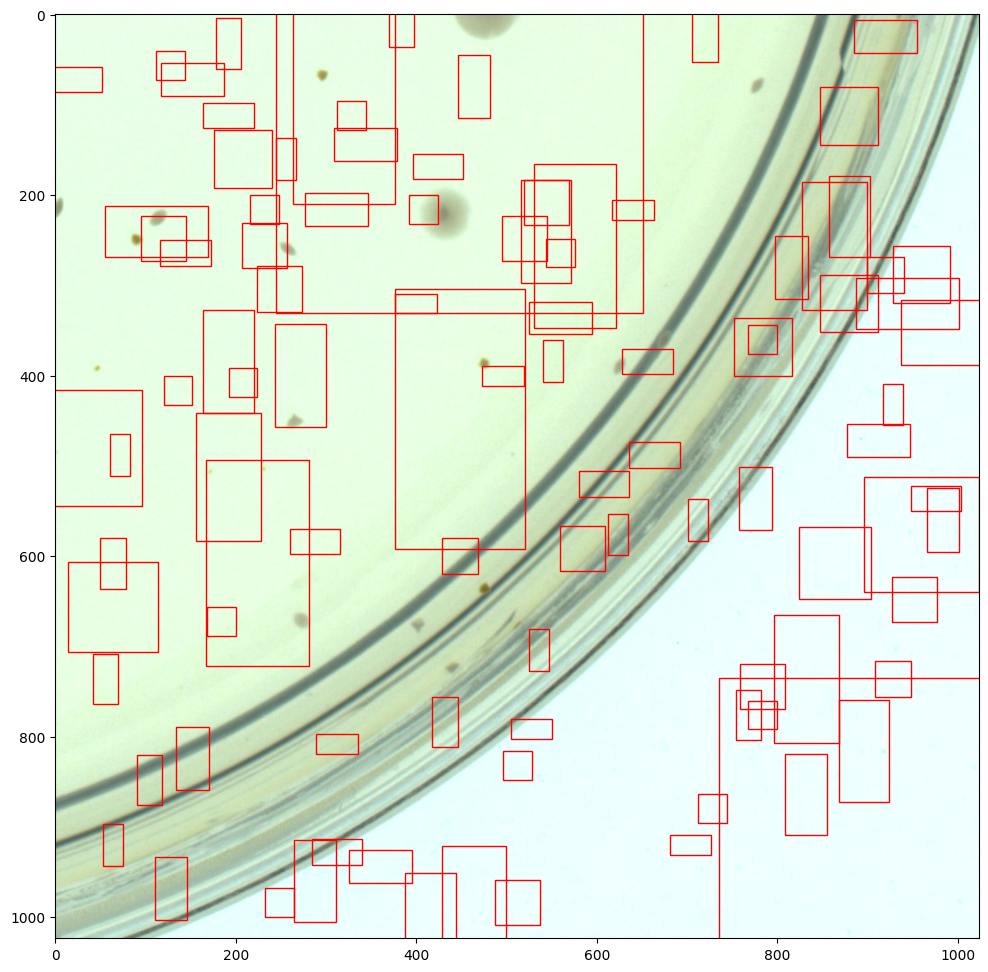

In [22]:
config = {
    'index_image': 1,
    'image_size': (1024, 1024),
    'transform': A.RandomCrop,
    'anchor_size_coefficient': 1,
    'dataset_directory': DATA_VALIDATION_DIR}

visualize_anchors(**config)

Demonstrate something which worked less:
RandomCrop 2048-2048

The result was 60% recall and 80% of precision.

Compute class mapping for TEST dataset


100%|██████████| 93/93 [00:00<00:00, 1576.23it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.17777778..1.1333333].


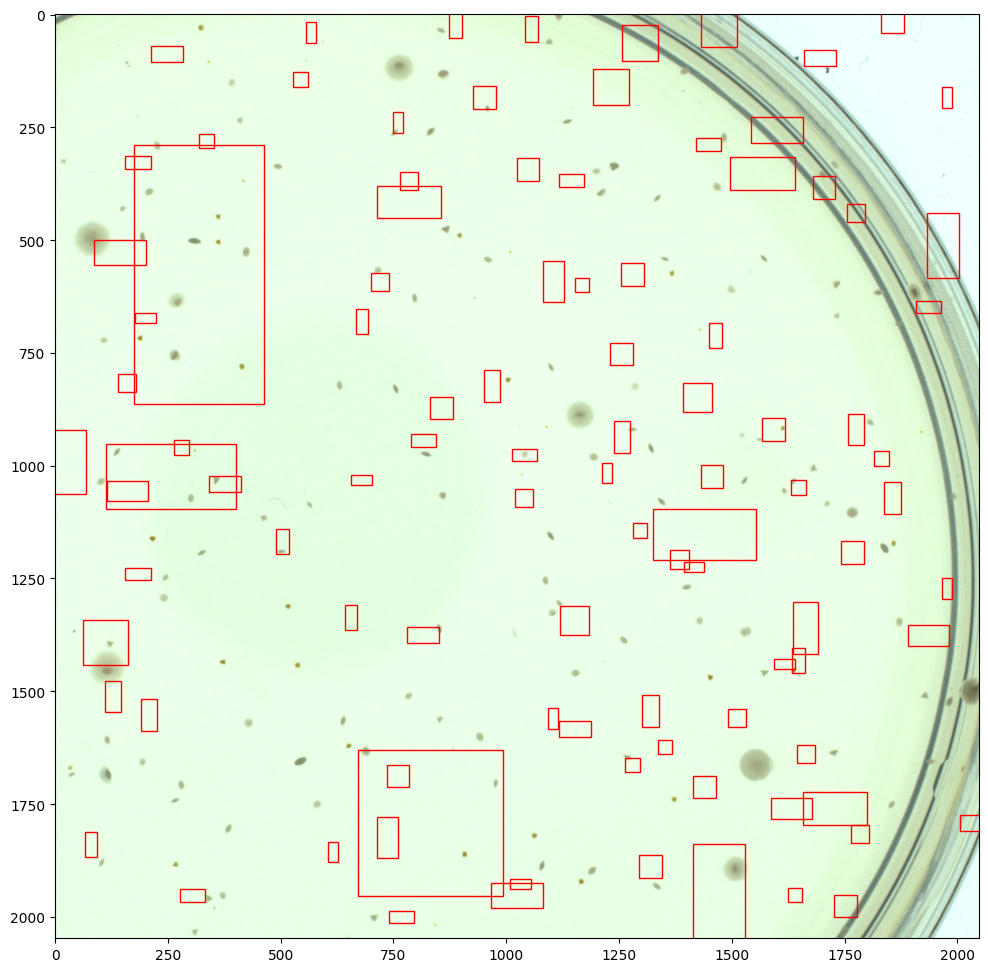

In [24]:
config = {
    'index_image': 1,
    'image_size': (2048, 2048),
    'transform': A.RandomCrop,
    'anchor_size_coefficient': 1,
    'dataset_directory': DATA_VALIDATION_DIR}

visualize_anchors(**config)

We noticed that when we inferred with our previous model on test dataset (with image resizing of 2048x2048), the result was not good:
only *big* bacterias were detected by the model. Looking at the anchor boxes designed by the model (see in the picture below), we correctly understand why.

Compute class mapping for TEST dataset


100%|██████████| 93/93 [00:00<00:00, 645.93it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.13777778..1.1333333].


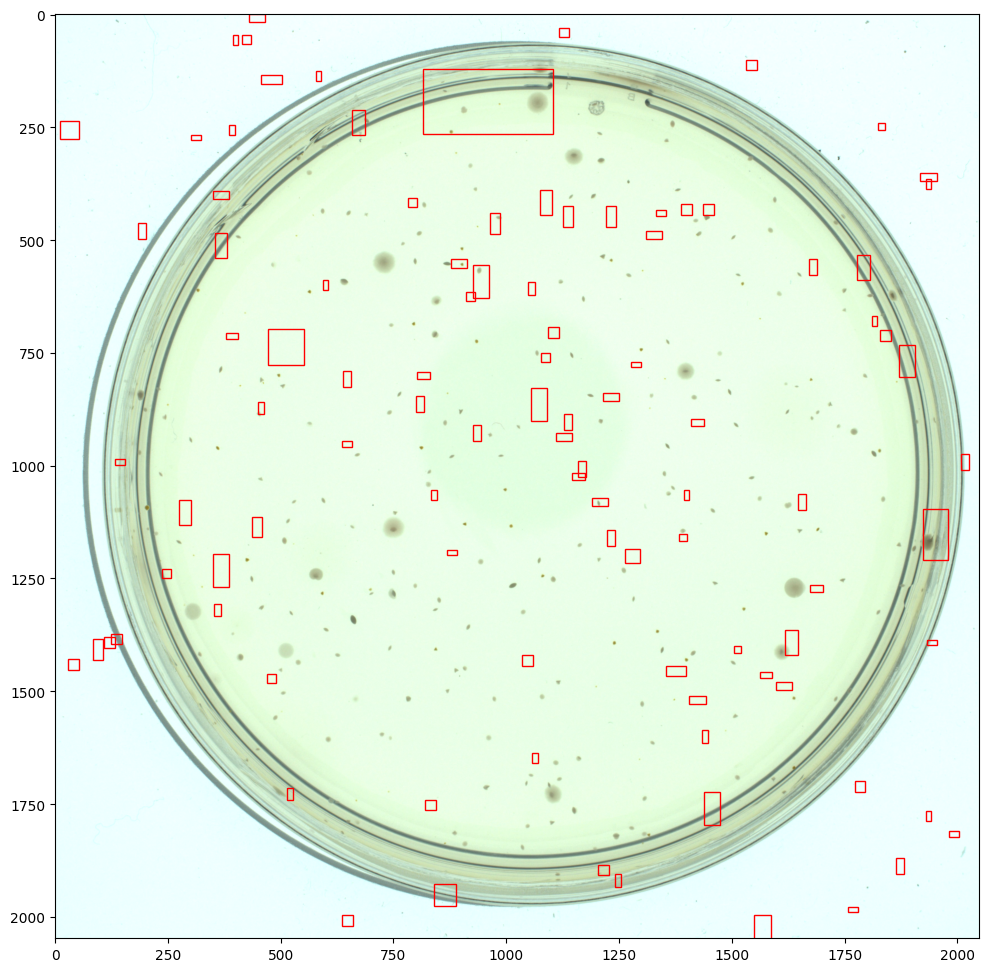

In [28]:
config = {
    'index_image': 1,
    'image_size': (2048, 2048),
    'transform': A.Resize,
    'anchor_size_coefficient': 0.5,
    'dataset_directory': DATA_VALIDATION_DIR}

visualize_anchors(**config)

One solution could be to shrink the size of the anchor boxes. In this example, we used a coefficient 1/2 to weight the anchor boxes size. 

Compute class mapping for TEST dataset


100%|██████████| 93/93 [00:00<00:00, 658.23it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.15555556..1.1333333].


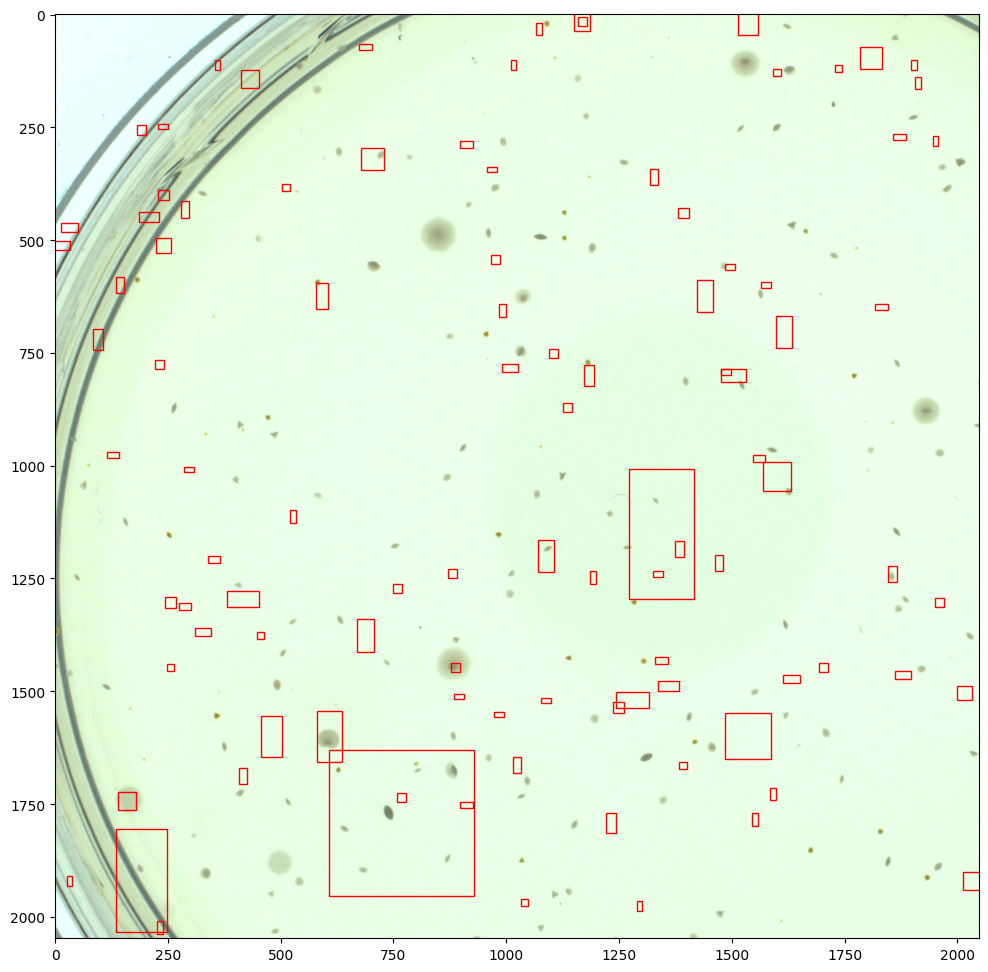

In [27]:
config = {
    'index_image': 1,
    'image_size': (2048, 2048),
    'transform': A.RandomCrop,
    'anchor_size_coefficient': 0.5,
    'dataset_directory': DATA_VALIDATION_DIR}

visualize_anchors(**config)

### Conclusion 

3 solutions exist to fit the anchor boxes to a custom dataset:
 - Tweak size and aspect ratios manually
 - K-mean clustering (solution used by YOLO)
  - Learn anchor box configuration (**MetaAnchor** model -> https://arxiv.org/pdf/1807.00980)
 

We have to take into account that if the center of the bounding box and anchor box differ, this will reduce the IOU. Even if you have small anchor boxes, you may miss some ground truth boxes if the stride between anchor boxes is wide. One way to ameliorate this is to lower the IOU threshold from 50% to 40%.

Beware that increasing the total number of anchor boxes will exponentially increase computation costs. Whereas generating fewer anchors that have a higher chance to overlap with ground truth will both improve accuracy and reduce computation costs.

Bibliography: 
- https://towardsdatascience.com/anchor-boxes-the-key-to-quality-object-detection-ddf9d612d4f9
- https://medium.com/@beam_villa/enhance-object-detection-performance-through-anchor-box-optimization-761b68a1a4a4
- https://medium.com/@yerdaulet.zhumabay/generating-anchor-boxes-by-k-means-82f11c690b82
- https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/configuring_jobs.md#anchor-box-parameters